In [1]:
from pyquil.quil import Program
from pyquil.quilatom import Parameter, quil_exp
from pyquil.quilbase import DefGate
from pyquil.gates import H, RX, MEASURE, RZ, CPHASE
from pyquil.quilbase import Declare
from pyquil.api import get_qc
import numpy as np
from our_noise_new import add_noise_to_program

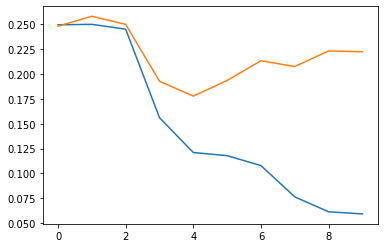

In [17]:

def adiabatic_shift(qc, qubits, steps, trials, noise=False):
    p = Program()
    for i in range(qubits):
        p += H(i)
    
    angles=np.pi/2*np.array(range(steps))/steps
    for theta in angles:
        for i in range(qubits):
            p += RX(-np.cos(theta), i)
        beta = np.sin(theta)
        for i in range(qubits-1) :
            p += RZ(-beta,i)
            p += CPHASE(2*beta,i,i+1)
        p += RZ(beta,qubits-1)
    ro = p.declare('ro', 'BIT', qubits)
    for i in range(qubits):
        p += MEASURE(i, ("ro", i))
    p.wrap_in_numshots_loop(trials)
    if noise:
        p = add_noise_to_program(qc, p, recompile=False)
    bitstrings = qc.run(p).readout_data.get("ro")
    d = 0
    for i in bitstrings:
        for q in range(qubits-1):
            d += (i[q] != i[q+1])
    d = d/(trials*(2*(qubits-1)))
    return d

maxN = 10
qubits = 8
trials = 500
# qc = get_qc(str(qubits) + 'q-qvm')
qc = get_qc('Aspen-M-3', as_qvm=True)
no_noise = np.zeros(maxN)
noisy = np.zeros(maxN)
for i in range (maxN):
    no_noise[i] = adiabatic_shift(qc, qubits=qubits, steps=i, trials=trials, noise=False)
    noisy[i] = adiabatic_shift(qc, qubits=qubits, steps=i, trials=trials, noise=True)

import matplotlib.pyplot as plt
plt.plot(no_noise)
plt.plot(noisy)
# plt.yscale('log')
# plt.xscale('log')
